In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import os

# Download dan ekstrak dataset (dari kaggle)

Kode di bawah dapat berjalan jika terdapat file `kaggle.json` yang berisi username dan token dari kaggle API

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download dataset

In [8]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 144MB/s]


Ekstrak dataset

In [9]:
!unzip "/content/emotions-dataset-for-nlp.zip" -d "/content/emotions-dataset-for-nlp"

Archive:  /content/emotions-dataset-for-nlp.zip
  inflating: /content/emotions-dataset-for-nlp/test.txt  
  inflating: /content/emotions-dataset-for-nlp/train.txt  
  inflating: /content/emotions-dataset-for-nlp/val.txt  


# Load dataset menjadi pandas dataframe

In [10]:
BASE_DIR= '/content/emotions-dataset-for-nlp'

os.listdir(BASE_DIR)

['val.txt', 'train.txt', 'test.txt']

Dataset terbagi menjadi 3, jadi terlebih dahulu kita menggabungkannya menjadi satu lalu barulah diload sebagai pandas dataframe.

In [11]:
df= pd.concat([pd.read_csv(os.path.join(BASE_DIR, i), header=None, delimiter=';') for i in os.listdir(BASE_DIR)])
df.columns= ['text', 'emotion']

df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


Dataset berisi 20 ribu sampel

In [12]:
len(df)

20000

Dataframe terdiri dari 2 kolom, `text` sebagai kalimatnya, dan kolom `emotion` yang merupakan emosi  atau perasaan dari kalimat bersangkutan, sebagai classnya. 

In [13]:
df['emotion'].unique()

array(['sadness', 'love', 'anger', 'joy', 'fear', 'surprise'],
      dtype=object)

# Pra-proses dataframe

Melakukan One-Hot Encode pada kolom `emotion`

In [14]:
emotion= pd.get_dummies(df['emotion'])
df_encoded= pd.concat([df['text'], emotion], axis=1)

df_encoded

,text,anger,fear,joy,love,sadness,surprise
0,im feeling quite sad and sorry for myself but ...,0,0,0,0,1,0
1,i feel like i am still looking at a blank canv...,0,0,0,0,1,0
2,i feel like a faithful servant,0,0,0,1,0,0
3,i am just feeling cranky and blue,1,0,0,0,0,0
4,i can have for a treat or if i am feeling festive,0,0,1,0,0,0
...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,1,0,0,0,0,0
1996,im feeling a little cranky negative after this...,1,0,0,0,0,0
1997,i feel that i am useful to my people and that ...,0,0,1,0,0,0
1998,im feeling more comfortable with derby i feel ...,0,0,1,0,0,0


Melakukan splitting data

In [15]:
X= df_encoded['text'].values
y= df_encoded.drop('text', axis=1).values

x_train, x_val, y_train, y_val= train_test_split(X, y, test_size=0.2)

len(x_train), len(x_val)

(16000, 4000)

Melakukan tokenizing

In [16]:
num_words= 10000

tokenizer = Tokenizer(num_words= num_words, oov_token='-')

tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_val)

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

Menentukan batas/threshold kata per kalimat, berdasarkan kalimat terpanjang pada data dikurangi 20.

In [17]:
max_text_words= max(df['text'].map(lambda x: len(x.split(' '))))-25
# max_text_words= int(df['text'].map(lambda x: len(x.split(' '))).mean()) + 20

max_text_words

41

 Kemudian padding

In [18]:
x_train_padded= pad_sequences(x_train, maxlen=max_text_words, padding='post', truncating = 'post')
x_val_padded= pad_sequences(x_val, maxlen=max_text_words, padding='post', truncating = 'post')

x_train_padded

array([[  2, 117,  41, ...,   0,   0,   0],
       [  2,  90,  72, ...,   2, 138,  84],
       [ 16,  26, 224, ...,   0,   0,   0],
       ...,
       [  2, 215,   5, ...,   0,   0,   0],
       [  2,   3, 902, ...,   0,   0,   0],
       [ 16, 157,  84, ...,   0,   0,   0]], dtype=int32)

# Pelatihan Model

In [19]:
EMBEDDING_DIM= 128

model = keras.models.Sequential([
    layers.Embedding(num_words, EMBEDDING_DIM, input_length=max_text_words),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(256),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.1, patience=0, min_lr=1e-5, min_delta=0.01)

history = model.fit(x_train_padded, y_train, epochs=10, 
                    validation_data=(x_val_padded, y_val), verbose=2, callbacks=[reduce_lr])

Epoch 1/10
500/500 - 16s - loss: 1.4254 - accuracy: 0.3587 - val_loss: 1.1054 - val_accuracy: 0.4495 - lr: 0.0010 - 16s/epoch - 31ms/step
Epoch 2/10
500/500 - 6s - loss: 0.9964 - accuracy: 0.4703 - val_loss: 0.9857 - val_accuracy: 0.4947 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 3/10
500/500 - 6s - loss: 0.8657 - accuracy: 0.5306 - val_loss: 0.9100 - val_accuracy: 0.5335 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 4/10
500/500 - 6s - loss: 0.7115 - accuracy: 0.6253 - val_loss: 0.6790 - val_accuracy: 0.7418 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 5/10
500/500 - 6s - loss: 0.3654 - accuracy: 0.8853 - val_loss: 0.3837 - val_accuracy: 0.8920 - lr: 0.0010 - 6s/epoch - 13ms/step
Epoch 6/10
500/500 - 6s - loss: 0.2208 - accuracy: 0.9289 - val_loss: 0.3417 - val_accuracy: 0.9000 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 7/10
500/500 - 6s - loss: 0.1584 - accuracy: 0.9461 - val_loss: 0.2717 - val_accuracy: 0.9087 - lr: 0.0010 - 6s/epoch - 13ms/step
Epoch 8/10
500/500 - 6s - loss: 0.1176 - accur

# Visualisasi akurasi dan loss saat proses pelatihan

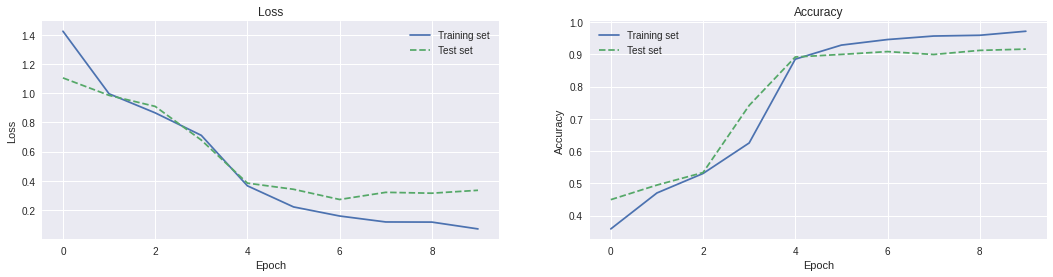

In [21]:
plt.style.use('seaborn')

loss= history.history['loss']
val_loss= history.history['val_loss']

accuracy= history.history['accuracy']
val_accuracy= history.history['val_accuracy']

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()